In [12]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from utils import (
    SigLIPExperiment,
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fixed Large Temperature

Ablation study with fixed large temperature instead of growing trainable temperature.

In [13]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
# Test a range of initial fixed relative biases
initial_relative_biases = [-1,-1/2, 0,1/2,1]
bias_is_trainable = False
temperature_is_trainable = False

t = 100  
final_losses = []
final_temps = []
final_embeddings = []

#print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

for rb in initial_relative_biases:
    print(f"\nInitial Relative Bias: {rb:.2f}")
    
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str
    )

    U_final, V_final, criterion_final, losses_history = experiment.train(
        relative_bias=rb,
        temperature=t,
        trainable_temp=temperature_is_trainable,
        trainable_bias=bias_is_trainable
    )
    
    final_loss = losses_history[-1]
    final_temp = criterion_final.get_temperature()
    
    final_losses.append(final_loss)
    final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar
    

    print(f"Final Loss: {final_loss:.4f}")
    print(f"Final Temperature: {final_temp:.4f}")

    final_embeddings.append((U_final, V_final))

Running experiments with: n_classes=100, dim=10, n_epochs=10000

Initial Relative Bias: -1.00
Final Loss: 18.2241
Final Temperature: 100.0000

Initial Relative Bias: -0.50
Final Loss: 0.1695
Final Temperature: 100.0000

Initial Relative Bias: 0.00
Final Loss: 0.1621
Final Temperature: 100.0000

Initial Relative Bias: 0.50
Final Loss: 0.1161
Final Temperature: 100.0000

Initial Relative Bias: 1.00
Final Loss: 0.1771
Final Temperature: 100.0000


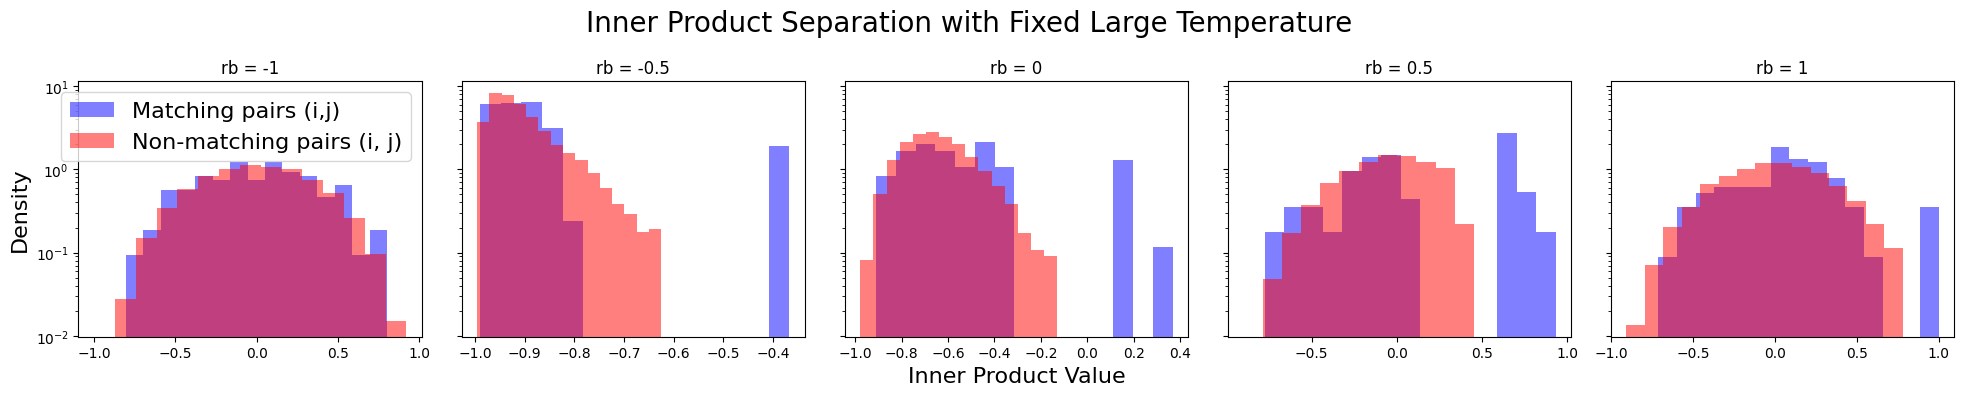

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

fig.suptitle('Inner Product Separation with Fixed Large Temperature', fontsize=20)
titles = ["rb = "+str(rb) for rb in initial_relative_biases]
for i, ax in enumerate(axes):

    U_final, V_final = final_embeddings[i]
    inner_products = torch.matmul(U_final, V_final.t())
        # Get matching pairs (diagonal elements)
    matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
        # Get non-matching pairs (off-diagonal elements)
    mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
    non_matching_pairs = inner_products[mask].detach().cpu().numpy()

        # Create histogram plot
    ax.hist(matching_pairs, bins= 15, alpha=0.5, label='Matching pairs (i,j)', color='blue', density=True, log = True)
    ax.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i, j)', color='red', density=True, log = True)

    
    ax.set_title(titles[i])

    
    if i == 0:
        ax.set_ylabel('Density', fontsize = 16)
        ax.legend(fontsize= 16)
    if i == 2:
        ax.set_xlabel('Inner Product Value', fontsize = 16)
    
plt.tight_layout()

plt.savefig("logs/ablationfixedlargetemperature.png",dpi=300, bbox_inches='tight')
plt.show()

# Trainable Temperature 

In [15]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'
# Test a range of initial relative biases
initial_relative_biases = [-1,-1/2, 0,1/2,1]
bias_is_trainable = False
temperature_is_trainable = True # traibale temperature

t = 10  
final_losses = []
final_temps = []
final_embeddings = []

#print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

for rb in initial_relative_biases:
    print(f"\nInitial Relative Bias: {rb:.2f}")
    
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str
    )

    U_final, V_final, criterion_final, losses_history = experiment.train(
        relative_bias=rb,
        temperature=t,
        trainable_temp=temperature_is_trainable,
        trainable_bias=bias_is_trainable
    )
    
    final_loss = losses_history[-1]
    final_temp = criterion_final.get_temperature()
    
    final_losses.append(final_loss)
    final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar
    

    print(f"Final Loss: {final_loss:.4f}")
    print(f"Final Temperature: {final_temp:.4f}")

    final_embeddings.append((U_final, V_final))

Running experiments with: n_classes=100, dim=10, n_epochs=10000

Initial Relative Bias: -1.00
Final Loss: 0.6931
Final Temperature: 6.4938

Initial Relative Bias: -0.50
Final Loss: 0.0000
Final Temperature: 124.3492

Initial Relative Bias: 0.00
Final Loss: 0.0000
Final Temperature: 74.5701

Initial Relative Bias: 0.50
Final Loss: 0.0000
Final Temperature: 64.8666

Initial Relative Bias: 1.00
Final Loss: 0.0069
Final Temperature: 26.6593


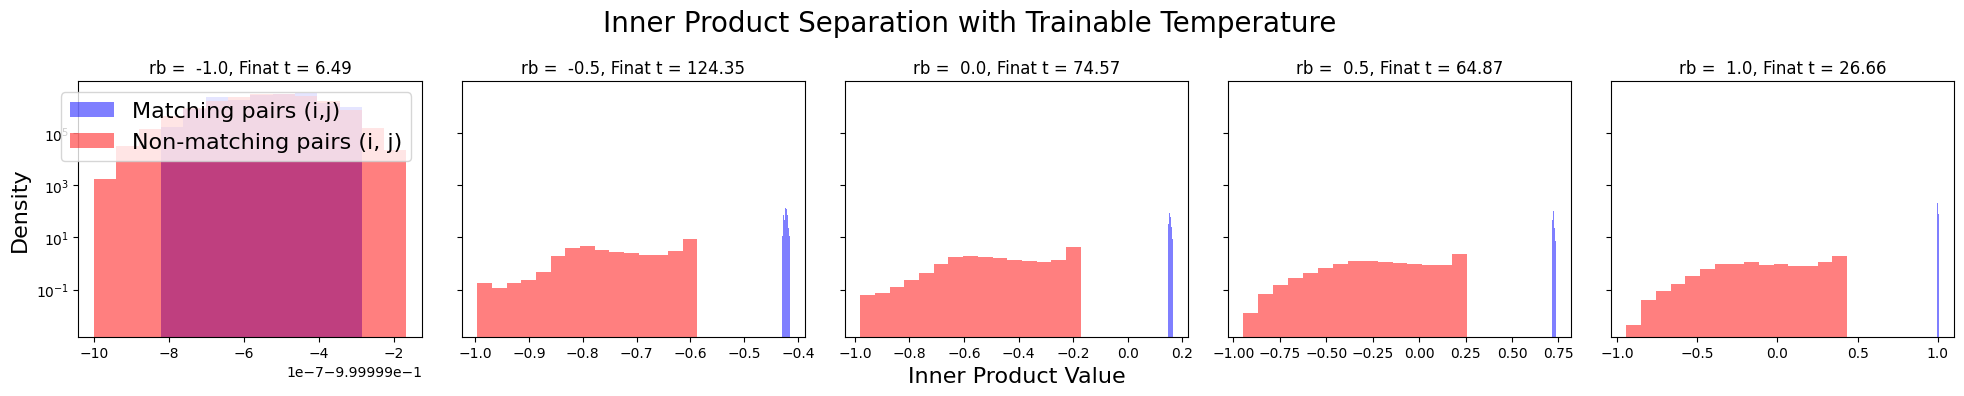

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

fig.suptitle('Inner Product Separation with Trainable Temperature', fontsize=20)
titles = [f"rb =  {rb:.1f}, Finat t = {final_temps[i]:.2f}" for i,rb in enumerate(initial_relative_biases)]
for i, ax in enumerate(axes):

    U_final, V_final = final_embeddings[i]
    inner_products = torch.matmul(U_final, V_final.t())
        # Get matching pairs (diagonal elements)
    matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
    if i>0:
        matching_pairs = matching_pairs + .002*np.random.normal(size = matching_pairs.shape)
        # Get non-matching pairs (off-diagonal elements)
    mask = ~torch.eye(n_classes, dtype=bool, device=device_str)
    non_matching_pairs = inner_products[mask].detach().cpu().numpy()

        # Create histogram plot
    ax.hist(matching_pairs, bins= 15, alpha=0.5, label='Matching pairs (i,j)', color='blue', density=True, log = True)
    ax.hist(non_matching_pairs, bins=15, alpha=0.5, label='Non-matching pairs (i, j)', color='red', density=True, log = True)

    
    ax.set_title(titles[i])

    
    if i == 0:
        ax.set_ylabel('Density', fontsize = 16)
        ax.legend(fontsize= 16)
    if i == 2:
        ax.set_xlabel('Inner Product Value', fontsize = 16)
    
plt.tight_layout()
plt.savefig("logs/ablationtrainablelargetemperature.png",dpi=300, bbox_inches='tight')
plt.show()
